Importing Libraries



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.framework import ops
from imgaug import augmenters as iaa





Loading training and test set


In [ ]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()


Normalizing data

In [ ]:
training_images=training_images / 255.0
test_images=test_images / 255.0

Data description


In [ ]:
print("Total training example: ",training_images.shape[0])
print("Total test example: ",test_images.shape[0])
print("Shape of a image:",training_images[0].shape)
print("Total unique labels: ",len(np.unique(training_labels)))


Total training example:  60000
Total test example:  10000
Shape of a image: (28, 28)
Total unique labels:  10


Dividing training set into train and validation set

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(training_images,
                                                    training_labels,
                                                    test_size=0.3,
                                                    random_state=42)

One hot encoding

In [ ]:
enc = OneHotEncoder()
train_labels_transformed=enc.fit_transform(np.transpose(train_labels.reshape(1,len(train_labels)))).toarray()
validation_labels_transformed=enc.fit_transform(np.transpose(validation_labels.reshape(1,len(validation_labels)))).toarray()
test_labels_transformed=enc.fit_transform(np.transpose(test_labels.reshape(1,len(test_labels)))).toarray()

Visualizing images


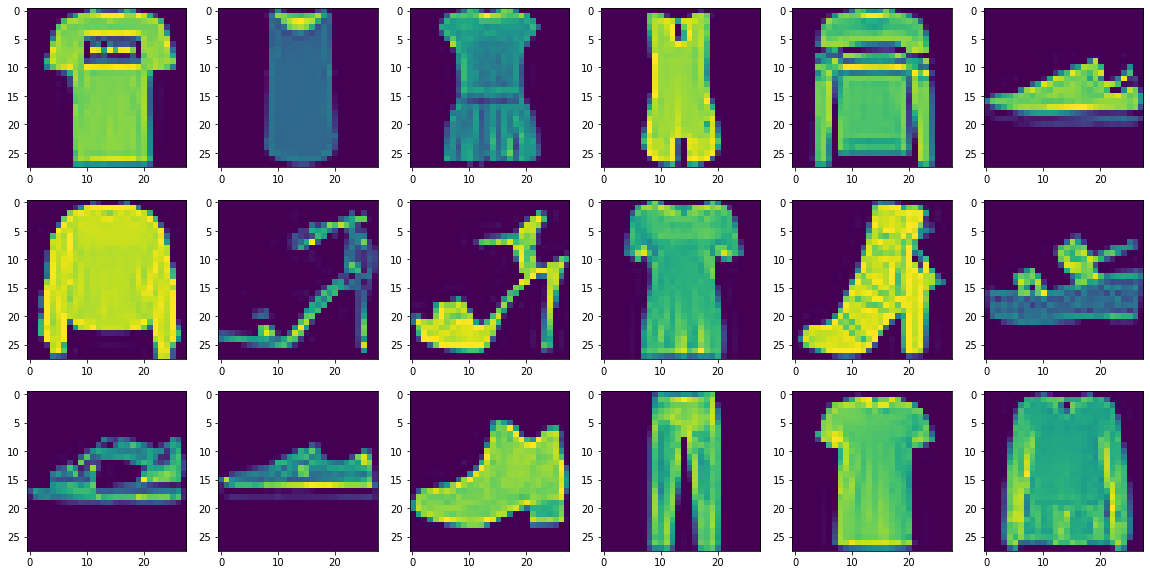

In [ ]:
import matplotlib.pyplot as plt
fig,a =  plt.subplots(3,6,squeeze=False,figsize=(20,10))
k=1
for i in range(0,3):
  for j in range(0,6):
    a[i][j].imshow(training_images[k])
    k+=1

Data augmentation pipeline

In [ ]:
def augment_data(x,y):

  
  seq_crop = iaa.Sequential([
      iaa.Crop(percent=(0.1, 0.1)) 
      
  ])


  seq_rot = iaa.Sequential([
      iaa.Affine(
          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-25, 25),
          shear=(-8, 8)  )                     
      
  ])

  seq_flip = iaa.Sequential([
      iaa.Fliplr(1.0)                   
  ])

  return np.concatenate((seq_crop(images=x),seq_rot(images=x),seq_flip(images=x)),axis=0),np.concatenate((y,y,y),axis=0)


Reshaping Data for input in CNN

In [ ]:
train_images=train_images.reshape(train_images.shape[0], 28, 28,1)
validation_images=validation_images.reshape(validation_images.shape[0], 28, 28,1)
test_images=test_images.reshape(test_images.shape[0], 28, 28,1)

Model

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(8, (2,2), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    # The second convolution
    tf.keras.layers.Conv2D(16, (2,2), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # The third convolution
    tf.keras.layers.Conv2D(16, (2,2), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 784 neuron hidden layer
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 8)         40        
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        528       
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 16)       

With early stopping and ReduceLROnPlateau( learning rate reduction )

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0)


batch_size = 250
num_epochs = 150
iterations = 5   


history1 = model.fit(
        train_images , train_labels_transformed,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(validation_images, validation_labels_transformed),
        callbacks=[early_stop,learning_rate_reduction]
        
    )

Epoch 1/150
168/168 [==============================] - 2s 9ms/step - loss: 0.8905 - accuracy: 0.6788 - val_loss: 2.0044 - val_accuracy: 0.4281
Epoch 2/150
168/168 [==============================] - 1s 7ms/step - loss: 0.5757 - accuracy: 0.7831 - val_loss: 1.1812 - val_accuracy: 0.5741
Epoch 3/150
168/168 [==============================] - 1s 7ms/step - loss: 0.4972 - accuracy: 0.8146 - val_loss: 0.5899 - val_accuracy: 0.7807
Epoch 4/150
168/168 [==============================] - 1s 7ms/step - loss: 0.4517 - accuracy: 0.8315 - val_loss: 0.4135 - val_accuracy: 0.8477
Epoch 5/150
168/168 [==============================] - 1s 7ms/step - loss: 0.4208 - accuracy: 0.8466 - val_loss: 0.3642 - val_accuracy: 0.8651
Epoch 6/150
168/168 [==============================] - 1s 7ms/step - loss: 0.4005 - accuracy: 0.8533 - val_loss: 0.3467 - val_accuracy: 0.8704
Epoch 7/150
168/168 [==============================] - 1s 7ms/step - loss: 0.3814 - accuracy: 0.8580 - val_loss: 0.3365 - val_accuracy: 0.8752

In [ ]:
evaluation = model.evaluate(test_images, test_labels_transformed)
print("test set accuracy: ",evaluation[1])


313/313 [==============================] - 1s 3ms/step - loss: 0.2359 - accuracy: 0.9196
test set accuracy:  0.9196000099182129


Modelling with data augmentation

In [ ]:
train_images , train_labels_transformed=augment_data(train_images , train_labels_transformed)
#validation_images, validation_labels_transformed=augment_data(validation_images, validation_labels_transformed)
#test_images, test_labels_transformed =augment_data(test_images, test_labels_transformed )

model2

In [ ]:
model2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(8, (2,2), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    # The second convolution
    tf.keras.layers.Conv2D(16, (2,2), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # The third convolution
    tf.keras.layers.Conv2D(16, (2,2), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 784 neuron hidden layer
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:

model2.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])



early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0)


batch_size = 250
num_epochs = 150
iterations = 5   


history1 = model2.fit(
        train_images , train_labels_transformed,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(validation_images, validation_labels_transformed),
        callbacks=[early_stop,learning_rate_reduction]
        
    )

Epoch 1/150
504/504 [==============================] - 4s 7ms/step - loss: 1.0193 - accuracy: 0.6249 - val_loss: 0.7808 - val_accuracy: 0.6898
Epoch 2/150
504/504 [==============================] - 3s 7ms/step - loss: 0.6972 - accuracy: 0.7354 - val_loss: 0.5577 - val_accuracy: 0.7889
Epoch 3/150
504/504 [==============================] - 3s 7ms/step - loss: 0.6073 - accuracy: 0.7723 - val_loss: 0.4342 - val_accuracy: 0.8395
Epoch 4/150
504/504 [==============================] - 3s 7ms/step - loss: 0.5597 - accuracy: 0.7917 - val_loss: 0.5902 - val_accuracy: 0.7779
Epoch 5/150
504/504 [==============================] - 3s 7ms/step - loss: 0.5292 - accuracy: 0.8038 - val_loss: 0.3729 - val_accuracy: 0.8599
Epoch 6/150
504/504 [==============================] - 3s 7ms/step - loss: 0.5085 - accuracy: 0.8102 - val_loss: 0.3986 - val_accuracy: 0.8533
Epoch 7/150
504/504 [==============================] - 3s 7ms/step - loss: 0.4931 - accuracy: 0.8169 - val_loss: 0.4267 - val_accuracy: 0.8346

In [ ]:
evaluation = model2.evaluate(test_images, test_labels_transformed)
print("test set accuracy: ",evaluation[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.2591 - accuracy: 0.9079
test set accuracy:  0.9078999757766724


#trash

batch_size = 250
num_epochs = 80
iterations = 5    

history = model.fit(
        train_images , train_labels_transformed,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(validation_images, validation_labels_transformed)
        validation_steps=256
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
 )
 
